In the NAIP data chapter in this textbook, you learned how to import a multi-band image into Python using rioxarray. You then plotted the data as a composite, RGB (and CIR) image using imshow() and calculated NDVI.

In that case, all bands of the data were stored in a single .tif file. However, sometimes data are downloaded in individual bands rather than a single file.

In this chapter, you will learn how to work with Landsat data in Python. Each band in a landsat scene is often stored in an individual .tif file. Thus you will need to grab the bands that you want to work with and then bring them into a xarrray DataFrame.

About Landsat Data
At over 40 years, the Landsat series of satellites provides the longest temporal record of moderate resolution multispectral data of the Earth’s surface on a global basis. The Landsat record has remained remarkably unbroken, proving a unique resource to assist a broad range of specialists in managing the world’s food, water, forests, and other natural resources for a growing world population. It is a record unmatched in quality, detail, coverage, and value. Source: USGS

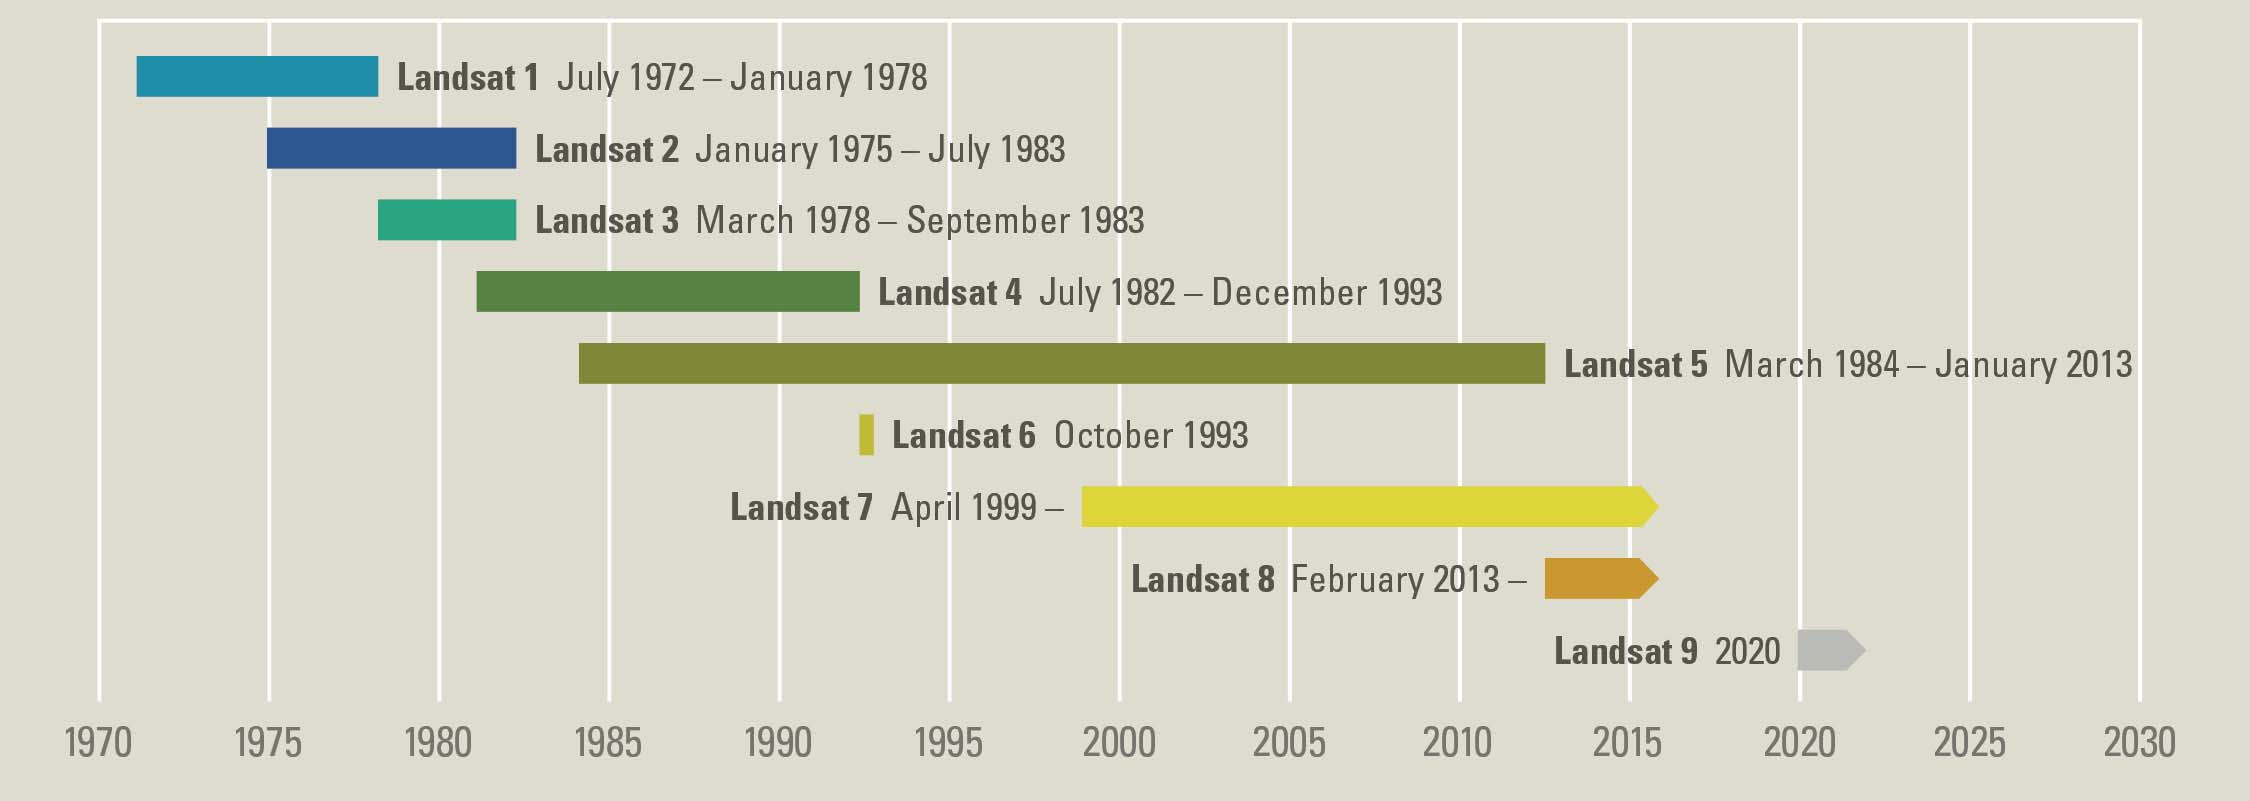

Landsat data are spectral and collected using a platform mounted on a satellite in space that orbits the earth. The spectral bands and associated spatial resolution of the first 9 bands in the Landsat 8 sensor are listed below.

Landsat 8 Bands

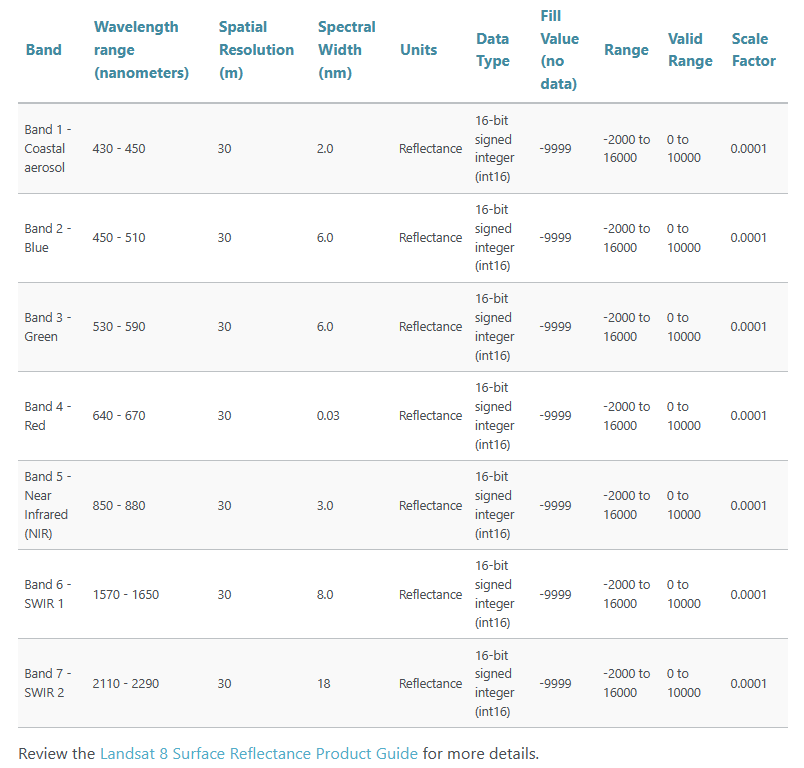

There are additional collected bands that are not distributed within the Landsat 8 Surface Reflectance Product such as the panchromatic band, which provides a finer resolution, gray scale image of the landscape, and the cirrus cloud band, which is used in the quality assessment process:

Band	Wavelength range (nanometers)	Spatial Resolution (m)	Spectral Width (nm)
Band 8 - Panchromatic	500 - 680	15	18
Band 9 - Cirrus	1360 - 1380	30	2.0
Understand Landsat Data
When working with landsat, it is important to understand both the metadata and the file naming convention. The metadata tell you how the data were processed, where the data are from and how they are structured.

The file names, tell you what sensor collected the data, the date the data were collected, and more.

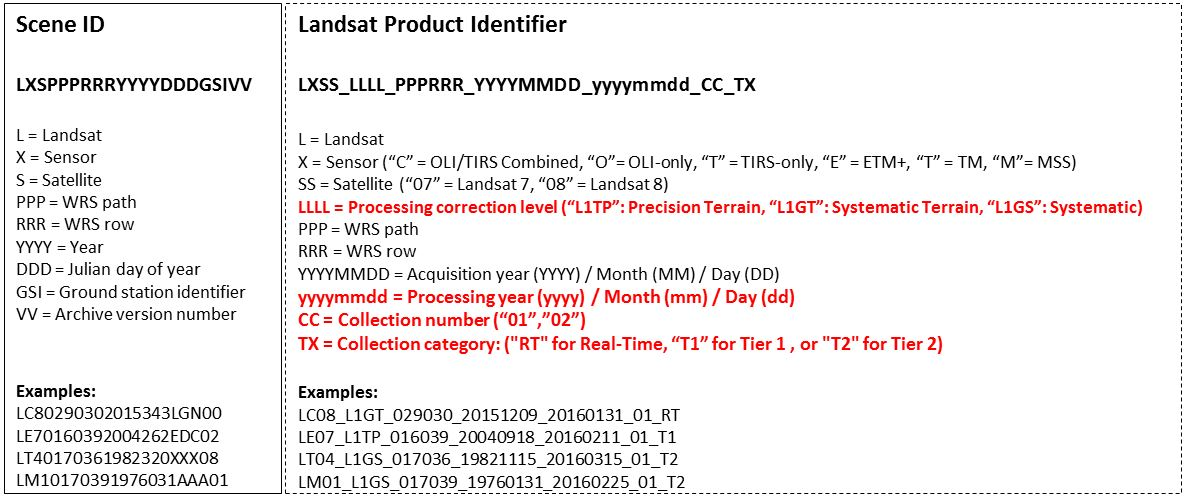

Landsat File Naming Convention
Landsat and many other satellite remote sensing data is named in a way that tells you a about:

When the data were collected and processed
What sensor was used to collect the data
What satellite was used to collect the data.
And more.

Here you will learn a few key components of the landsat 8 collection file name. The first scene that you work with below is named:

LC080340322016072301T1-SC20180214145802

First, we have LC08

L: Landsat Sensor
C: OLI / TIRS combined platform
08: Landsat 8 (not 7)

034032: The next 6 digits represent the path and row of the scene. This identifies the spatial coverage of the scene
Finally, you have a date. In your case as follows:

20160723: representing the year, month and day that the data were collected.
The second part of the file name above tells you more about when the data were last processed. You can read more about this naming convention using the link below.

[Learn more about Landsat 8 file naming conventions](https://www.usgs.gov/faqs/what-naming-convention-landsat-collections-level-1-scenes?qt-news_science_products=0#qt-news_science_products).

As you work with these data, it is good to double check that you are working with the sensor (Landsat 8) and the time period that you intend. Having this information in the file name makes it easier to keep track of this as you process your data.

In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [2]:
# Get list of all pre-cropped data and sort the data

# Create the path to your data
landsat_post_fire_path = os.path.join("data", "data", "cold-springs-fire",
                                      "landsat_collect",
                                      "LC080340322016072301T1-SC20180214145802",
                                      "crop")

# Generate a list of tif files
post_fire_paths = glob(os.path.join(landsat_post_fire_path,
                                        "*band*.tif"))

# Sort the data to ensure bands are in the correct order
post_fire_paths.sort()
post_fire_paths

['data/data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'data/data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'data/data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'data/data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'data/data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif',
 'data/data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif',
 'data/data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/cr

Next, open a single band from your Landsat scene. Below you use the .squeeze() method to ensure that output xarray object only has 2 dimensions and not three.

In [3]:
# Open a single band without squeeze - notice the first dimension is 1
band_1 = rxr.open_rasterio(post_fire_paths[0], masked=True)
band_1.shape

(1, 177, 246)

##### Tristan's note -> I think that calling `.squeeze()` on an array of shape three where `shape[0]` is 1 (i.e. 1 band) actually doesn't really do anything? Since a 2 dimensional array implicitly has a 3rd dimension of 1

In [4]:
# Open a single band using squeeze notice there are only 2 dimensions here
# when you use squeeze
band_1 = rxr.open_rasterio(post_fire_paths[0], masked=True).squeeze()
band_1.shape

(177, 246)

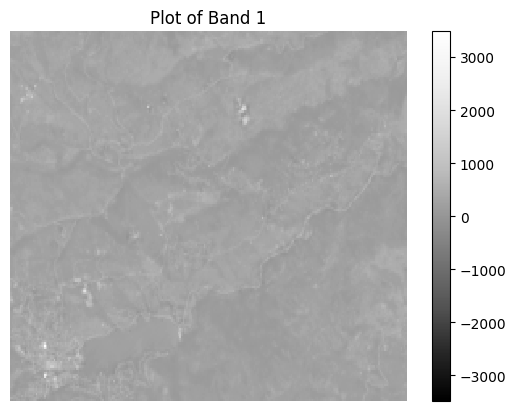

In [5]:
# Plot the data
f, ax=plt.subplots()
band_1.plot.imshow(ax=ax,
                  cmap="Greys_r")
ax.set_axis_off()
ax.set_title("Plot of Band 1")
plt.show()

Below is a function called open_clean_bands that opens a single tif file and returns an xarray object. In the following lessons you will build this function out to process and clean your Landsat data.

In [6]:
def open_clean_bands(band_path):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.
        
    Returns
    -------
    An single xarray object with the Landsat band data.

    """
     
    return rxr.open_rasterio(band_path, masked=True).squeeze()

The code below takes each band that you opened, and stacks it into a new single output array. NOTE: this approach is only efficient if you wish to process ALL of the bands in your data. Given the size of Landsat data, you likely will want to remove bands that you don’t need and if your study area is smaller than the entire image, you may also want to clip your data. You will learn how to clip and subset your data in the next lesson.

In [7]:
# Open all bands in a loop
all_bands = []
for i, aband in enumerate(post_fire_paths):
    all_bands.append(open_clean_bands(aband))
    # Assign a band number to the new xarray object
    all_bands[i]["band"]=i+1


In [9]:
# OPTIONAL: Turn list of bands into a single xarray object    
landsat_post_fire_xr = xr.concat(all_bands, dim="band") 
landsat_post_fire_xr

<xarray.DataArray (band: 7, y: 177, x: 246)>
array([[[ 446.,  476.,  487., ...,  162.,  220.,  260.],
        [ 393.,  457.,  488., ...,  200.,  235.,  296.],
        [ 364.,  393.,  388., ...,  246.,  298.,  347.],
        ...,
        [ 249.,  283.,  363., ...,  272.,  268.,  284.],
        [ 541.,  474.,  364., ...,  260.,  269.,  285.],
        [ 219.,  177.,  250., ...,  271.,  271.,  286.]],

       [[ 515.,  547.,  572., ...,  181.,  233.,  261.],
        [ 440.,  519.,  571., ...,  211.,  251.,  322.],
        [ 411.,  460.,  449., ...,  264.,  326.,  387.],
        ...,
        [ 387.,  326.,  427., ...,  288.,  278.,  301.],
        [ 554.,  654.,  433., ...,  276.,  276.,  293.],
        [ 291.,  174.,  291., ...,  292.,  290.,  304.]],

       [[ 782.,  772.,  843., ...,  335.,  390.,  411.],
        [ 684.,  771.,  836., ...,  363.,  412.,  511.],
        [ 656.,  725.,  706., ...,  425.,  518.,  599.],
        ...,
...
        ...,
        [1900., 1917., 2076., ..., 1722., 1891., 1890.],
        [1779., 1893., 1983., ..., 1645., 1847., 2090.],
        [1553., 1440., 1587., ..., 1562., 1689., 1964.]],

       [[2864., 2974., 3108., ...,  983., 1195., 1271.],
        [2527., 2827., 3008., ..., 1132., 1293., 1546.],
        [2141., 2427., 2433., ..., 1324., 1652., 1922.],
        ...,
        [1662., 1757., 1922., ..., 1463., 1472., 1519.],
        [1786., 1532., 1554., ..., 1374., 1423., 1450.],
        [1071.,  943.,  975., ..., 1524., 1461., 1518.]],

       [[1920., 1979., 2098., ...,  537.,  660.,  687.],
        [1505., 1863., 1975., ...,  651.,  747.,  924.],
        [1240., 1407., 1391., ...,  769., 1018., 1189.],
        ...,
        [1216., 1190., 1398., ...,  877.,  890.,  928.],
        [1517., 1184., 1078., ...,  846.,  810.,  820.],
        [ 660.,  593.,  623., ...,  984.,  909.,  880.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7
  * x            (x) float64 4.557e+05 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  3483
    STATISTICS_MEAN:     297.16466859584
    STATISTICS_MINIMUM:  -57
    STATISTICS_STDDEV:   119.61507774931
    scale_factor:        1.0
    add_offset:          0.0

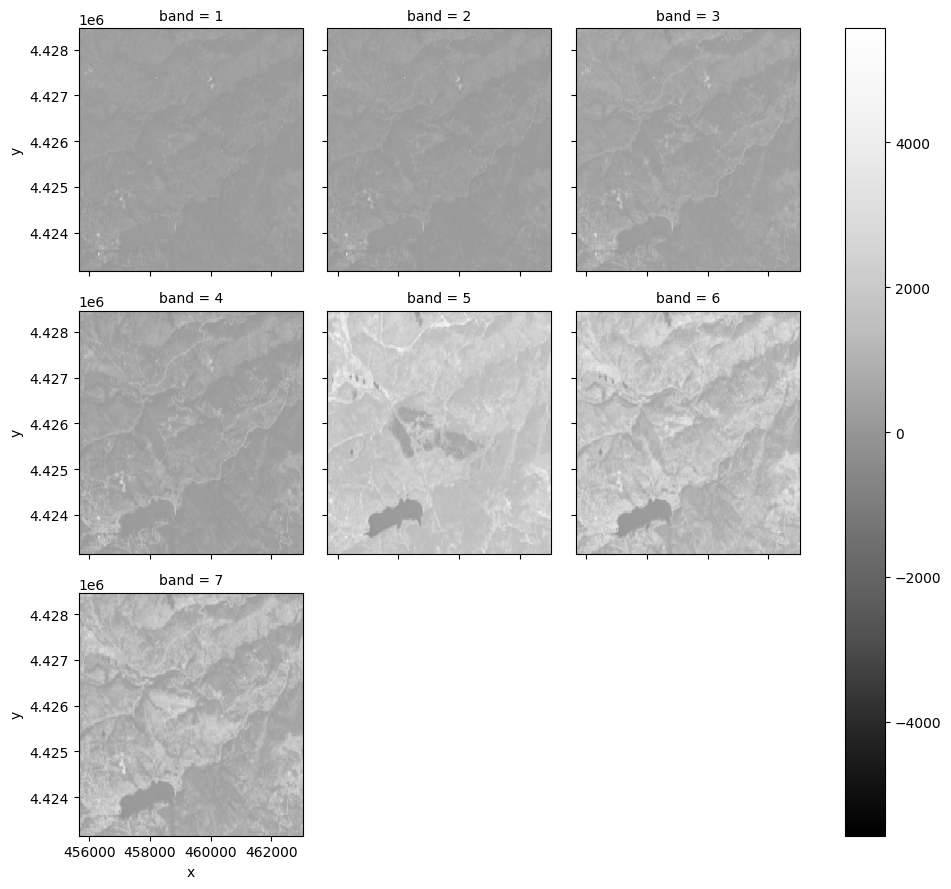

In [10]:
landsat_post_fire_xr.plot.imshow(col="band",
                                 col_wrap=3,
                                 cmap="Greys_r")
plt.show()

Plot RGB image
Just like you did with NAIP data, you can plot 3 band color composite images for Landsat using the earthpy ep.plot_rgb() function. Refer to the landsat bands in the table at the top of this page to figure out the red, green and blue bands. Or read the [ESRI landsat 8 band combinations post](https://blogs.esri.com/esri/arcgis/2013/07/24/band-combinations-for-landsat-8/).

ep.plot_rgb() requires:

the numpy array containing the bands that you wish to plot. You can access this by using xarray_name.values IMPORTANT: this array should be in xarray band order (bands first).

The numeric location of bands that you wish to plot in the array.

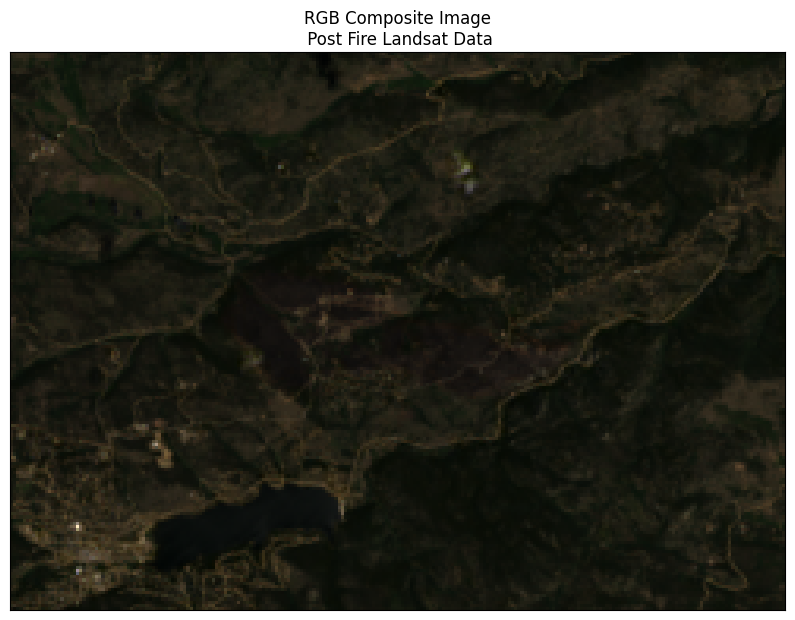

In [11]:
ep.plot_rgb(landsat_post_fire_xr.values,
            rgb=[3, 2, 1],
            title="RGB Composite Image\n Post Fire Landsat Data")
plt.show()

Notice that the image above looks dark. You can stretch the image as you did with the NAIP data, too. Below you use the stretch argument built into the earthpy plot_rgb() function. The str_clip argument allows you to specify how much of the tails of the data that you want to clip off. The larger the number, the most the data will be stretched or brightened.

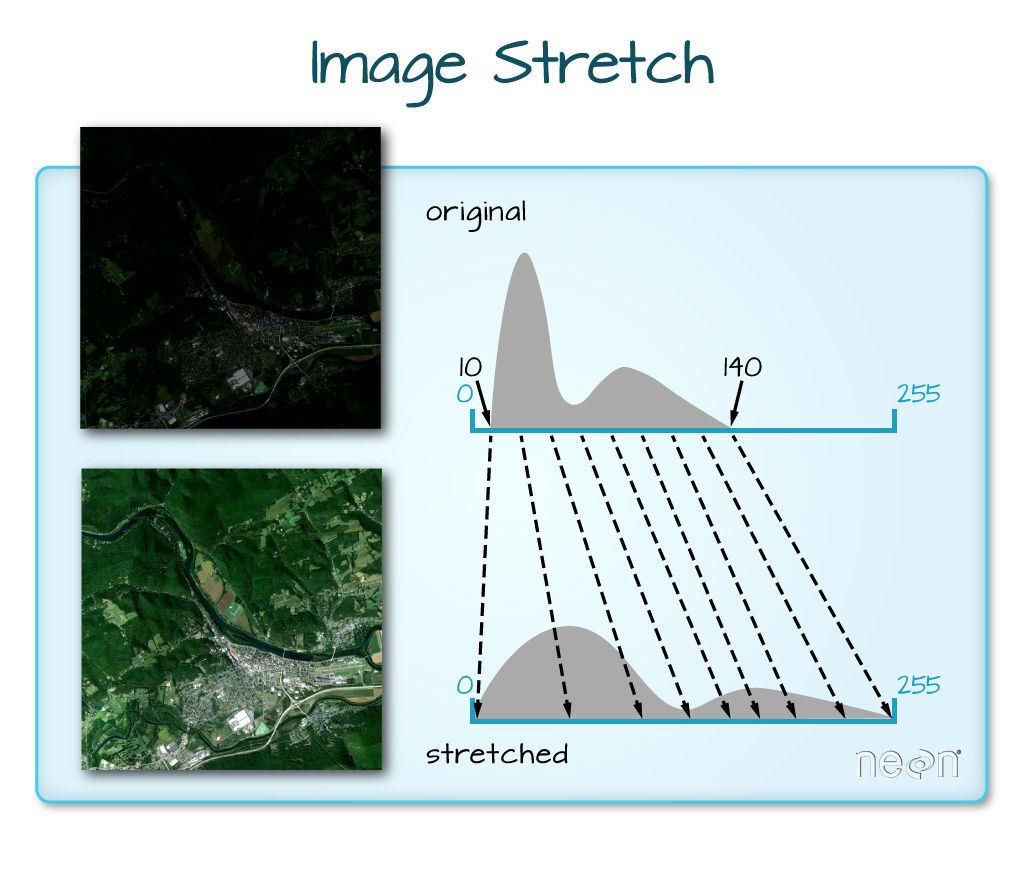

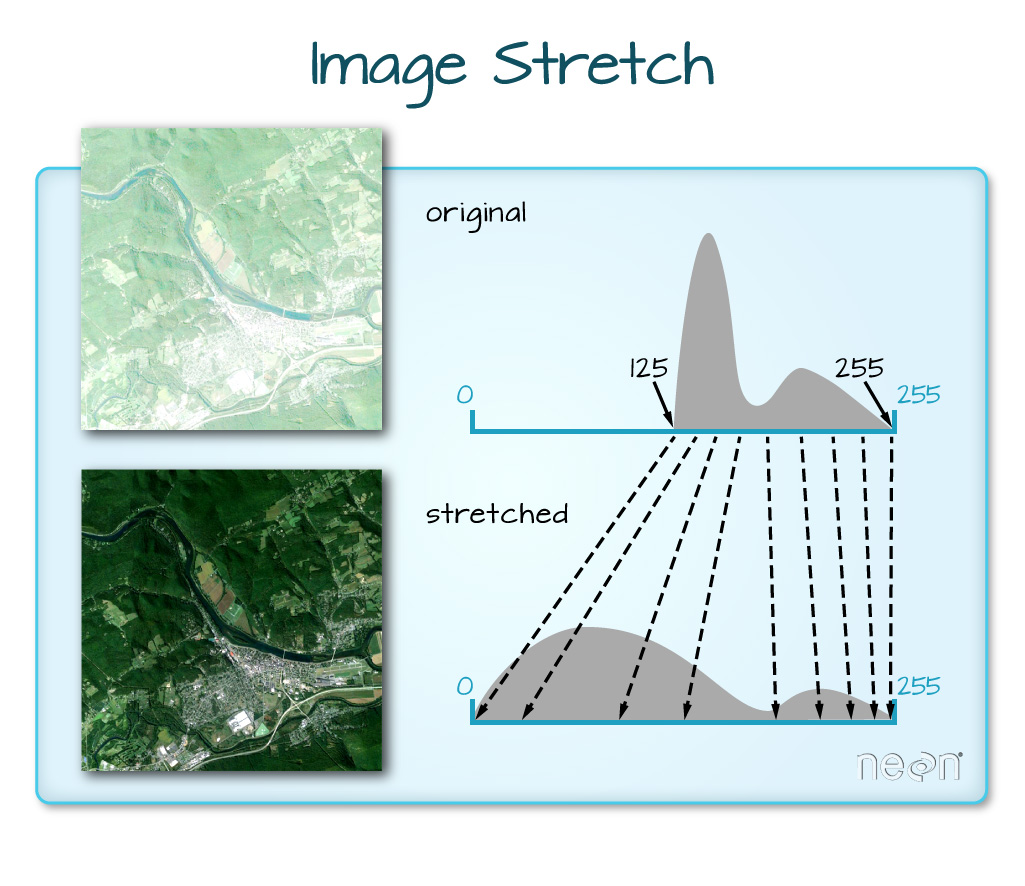

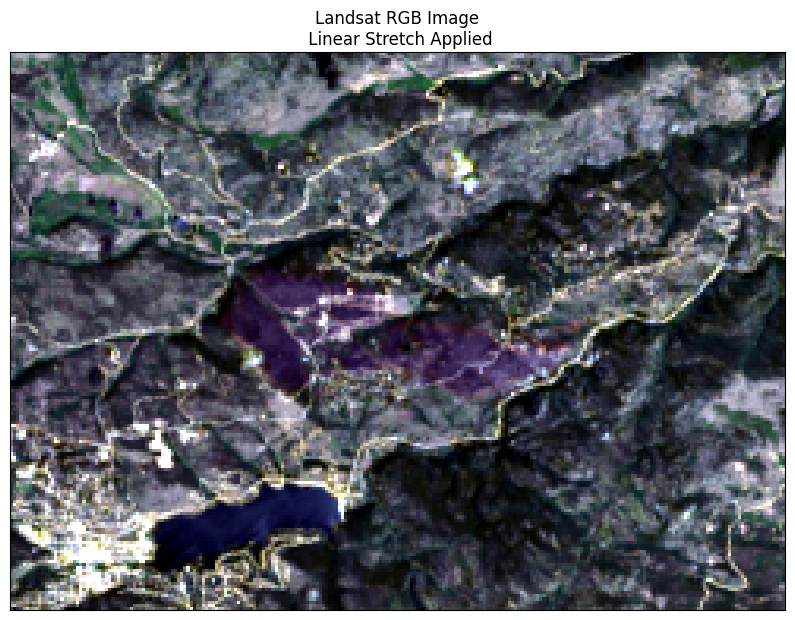

In [12]:
ep.plot_rgb(landsat_post_fire_xr.values,
            rgb=[3, 2, 1],
            title="Landsat RGB Image\n Linear Stretch Applied",
            stretch=True,
            str_clip=1)
plt.show()

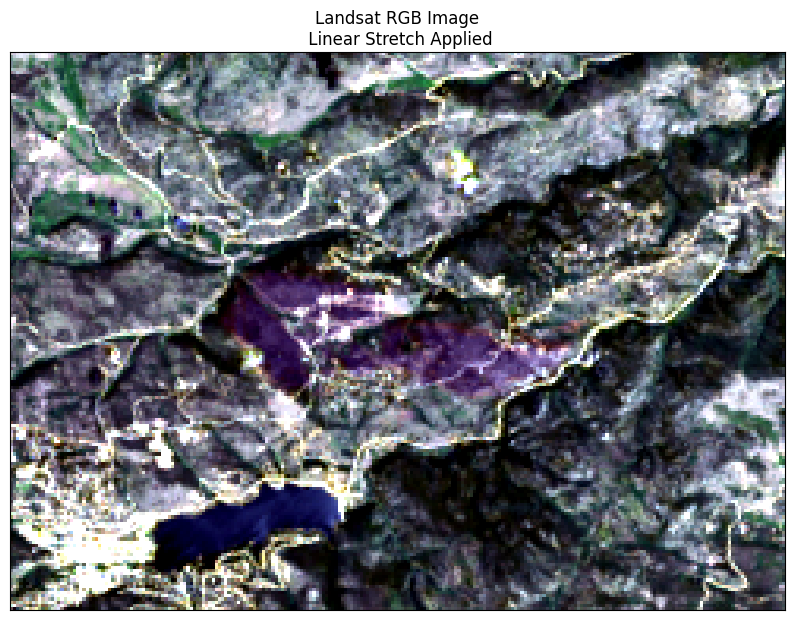

In [13]:
# Adjust the amount of linear stretch to futher brighten the image
ep.plot_rgb(landsat_post_fire_xr.values,
            rgb=[3, 2, 1],
            title="Landsat RGB Image\n Linear Stretch Applied",
            stretch=True,
            str_clip=4)
plt.show()

Raster Pixel Histograms
You can create a histogram to view the distribution of pixel values in the rgb bands plotted above.

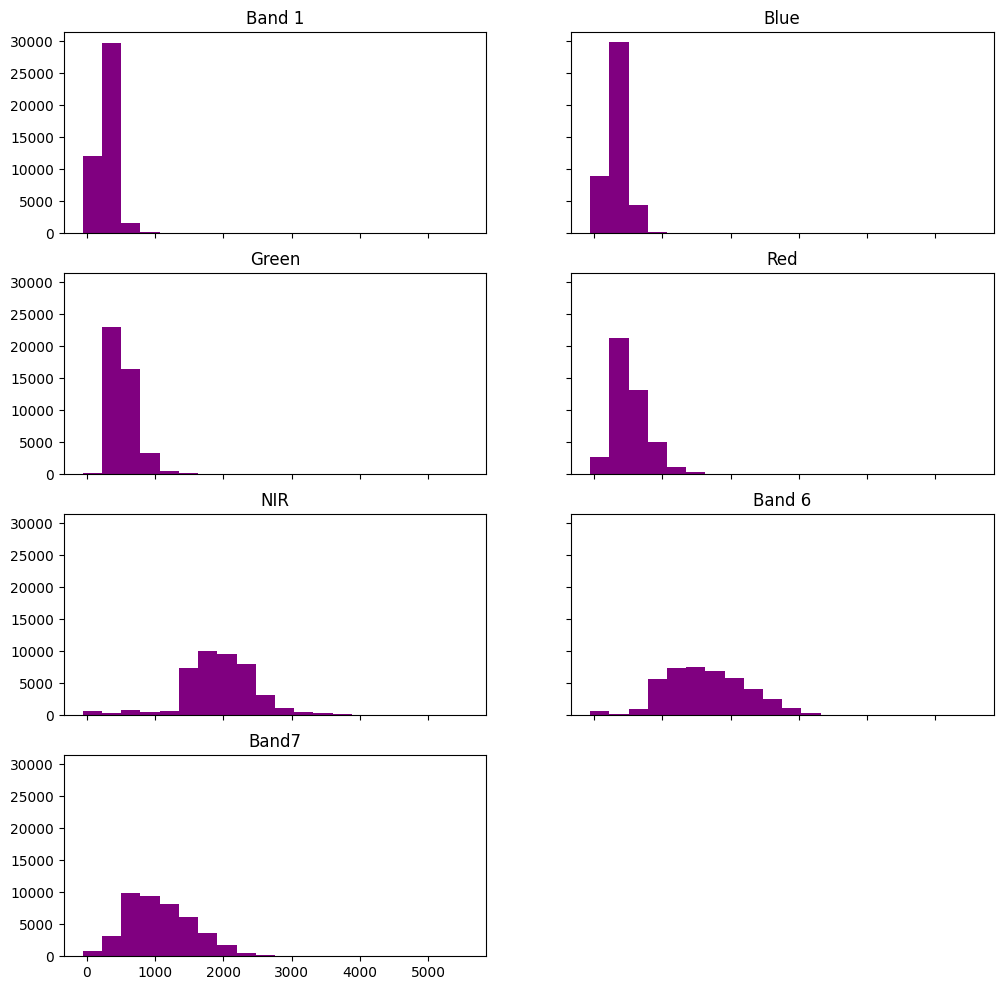

In [14]:
# Plot all band histograms using earthpy
band_titles = ["Band 1", 
               "Blue", 
               "Green", 
               "Red",
               "NIR", 
               "Band 6", 
               "Band7"]

ep.hist(landsat_post_fire_xr.values,
        title=band_titles)

plt.show()

Plot CIR
Now you’ve created a red, green blue color composite image. Remember red green and blue are colors that your eye can see.

Next, create a color infrared image (CIR) using landsat bands: 4,3,2.

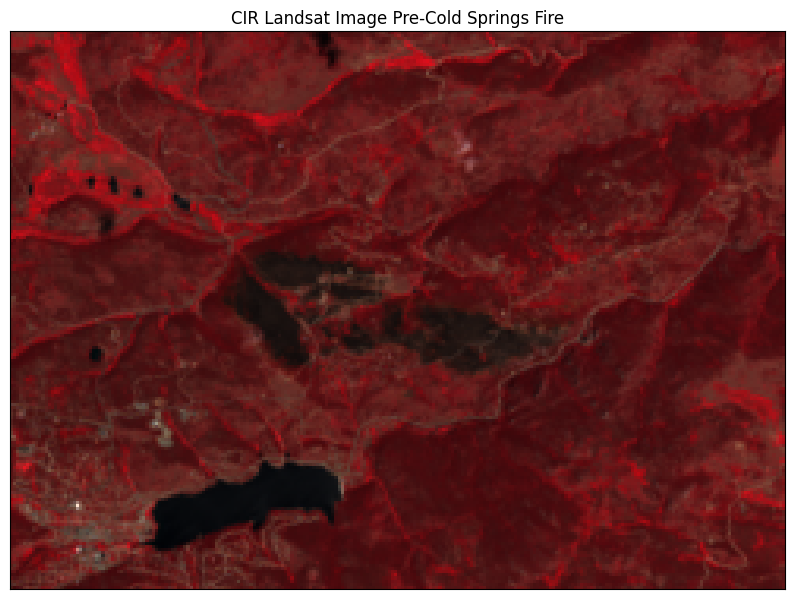

In [15]:
ep.plot_rgb(landsat_post_fire_xr.values,
            rgb=[4, 3, 2],
            title="CIR Landsat Image Pre-Cold Springs Fire",
            figsize=(10, 10))
plt.show()

 Data Tip: Landsat 8 Pre Collections Data

If you are working with Landsat data downloaded pre USGS collections, your data may be formatted and named slightly differently than the example shown on this page. Below is an explanation of the legacy Landsat 8 naming convention.

File: LC08_L1TP_034032_20160707_20170221_01_T1_sr_band1_crop.tif

Sensor	Sensor	Satellite	WRS path	WRS row	 	 	 	 
L	C	8	034	032	2016	0707	20170221	01
Landsat	OLI & TIRS	Landsat 8	path = 034	row = 032	year = 2016	Month = 7, day = 7	Processing Date: 2017-02-21 (feb 21 2017)	Archive (second version): 01
L: Landsat
X: Sensor
C = OLI & TIRS O = OLI only T = IRS only E = ETM+ T = TM M = MSS
S Satelite
PPP
RRR
YYYY = Year
DDD = Julian DAY of the year
GSI - Ground station ID
VV = Archive Version
[More here breaking down the file name](http://gisgeography.com/landsat-file-naming-convention/).

Julian day
We won’t spend a lot of time on Julian days. The julian day used to be used in Landsat pre collections file naming. However recently they have switched to a normal year-month-date format

See [this link](https://landweb.modaps.eosdis.nasa.gov/browse/calendar.html) that provide tables to help you convert julian days to actual date.